In [1]:
%matplotlib inline

# demonstration of sequence-to-sequence learning with attention

## background: sequence-to-sequence models

recurrent sequence-to-sequence models are a type of "many to many" ([karpathy 2015](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)) recurrent network in an encoder-decoder configuration. first, a recurrent network 'encodes' the input sequence, and then a recurrent decoder uses information from the encoder to generate an output sequence. this differs from recurrent models for POS tagging, entity recognition, etc. because it allows for input and output sequences of arbitrary and differing lengths. this is useful for tasks such as translation, where a sentence of *x* tokens (e.g. words, morphemes, characters) in the input language may have a translation of *y* tokens in the output language, where *x* may not equal *y*.

in the basic sequence-to-sequence model, all information from the encoder is passed to the decoder network through state transfer, where the final recurrent encoder state(s) are used to initialize the decoder state. we use the final hidden state *h* and cell state *c* from each encoder LSTM layer as the initial state for the decoder LSTM, but there are many alternatives and variations to this; the [wanasit article](https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html) upon which webase our attention implementation uses the final encoder *output state* to initialize both the cell and hidden state of the decoder in their one-layer LSTM model, and for an alternative approach, the [keras blog post](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) demonstrates a seq2seq model where inversely the final encoder state serves as the *input* *x* to the decoder at each timestep (the first model, before the main demonstration). however both these approaches rely on a single fixed-size representation of the encoder information.

a more effective approach may be to allow the network to "look back" at the encoder information at each timestep, but unlike the keras blog's basic implementation, allow the network to "focus" on different words at each timestep. this is implemented with *attention*.

## background: attention

attention is borrowed from work on computer vision, which was itself inspired by analogies to human visual processes. *Attention* instead considers a *weighted sum* over each timestep *t* (= token) of the input for each decoder timestep *s*, allowing the network to "focus on" different parts of the input when generating each token of the output. the analogy would be manually translating a sentence: in basic seq2seq, you only get to read the sentence one time, and then you must translate the whole sentence at once. with attention, you are allowed to look back at the source sentence before writing each word of the translation, and naturally you would focus on the word or words correlating with the part of the sentence you are writing next, ignoring words irrelevant to the current context. this 'focus' is captured in the attention matrix, which is multiplied by each output vector of the timestep, with higher weights corresponding to higher 'focus'. 

while the attention seen in _Bahdanau, Cho and Bengio 2015_ "Neural Machine Translation by Jointly Learning to Align and Translate" conducts this weighted sum on the *input* to the decoder RNN at each timestep, due to the fixed-graph restriction of `tensorflow` and the layer-wise approach taken in `keras`, the "global attention" from _Luong, Pham, Manning 2015_ "Effective Approaches to Attention-based Neural Machine Translation", particularly the simple "dot" attention, will allow for a simpler implementation. this implementation combines the 'basic' seq2seq decoder output state with  

## task: transliteration from Korean to English

we will build a toy sequence-to-sequence model that will transliterate Korean words in Hangul to the [McCune-Reischauer romanization](https://www.library.illinois.edu/ias/koreancollection/koreanromanizationtable/). on a linguistic/cultural note, this romanization system is no longer favored, with Korean linguistics using the [Yale format](https://en.wikipedia.org/wiki/Yale_romanization_of_Korean) and the South Korean government using its own [revised romanization](https://en.wikipedia.org/wiki/Revised_Romanization_of_Korean) for things such as street signs, documents, etc.

## data processing

here we will reead in the data, split the Korean into a sequence of graphemes, and split the English into a sequence of letters ("tokenization").

data is from: https://github.com/digitalprk/mcr_romanization

grapheme splitting code is from: https://github.com/Kcrong/separate-korean (thanks kcrong)

In [2]:
import json
import pandas as pd
import re
from separator import Separator

In [3]:
# read the csv using pandas
# separator is a tab (\t) and there are no column header rows
csvdata = pd.read_csv('data/wordlist.csv', sep='\t', header=None)
csvdata.head()

,0,1
0,화랑도,hwarangdo
1,해심,haesim
2,쨄,tchael
3,쇡,soek
4,언제쯤,ŏnjetchŭm


In [4]:
# get each column as a python list
kor_words = csvdata[0].tolist()
eng_words = csvdata[1].tolist()

In [5]:
# test the Separator
Separator(kor_words[0]).sep_all

['ㅎ', 'ㅘ', 'ㄹ', 'ㅏ', 'ㅇ', 'ㄷ', 'ㅗ']

In [6]:
# non-Korean characters will cause Separator to error
# so we must remove all non-Korean characters, including spaces
kor_words = [re.sub(r'[^가-힣ㄱ-ㅎ]', '', word) for word in kor_words]

In [7]:
# tokenize the Korean into lists of graphemes
kor_toks = [Separator(word).sep_all for word in kor_words]

In [8]:
# tokenize the English into lists of characters
# we lower-case and replace spaces with an underscore
eng_toks = [list(str(sent).lower().replace(' ', '_')) for sent in eng_words]

## data indexing

we will then truncate and/or "pad" the input and output to a fixed length of our choosing, create frequency-based character mappings, and convert the tokenized input to integer vectors, for input into the `keras` network.

more advanced training methods will "bucket" the data by similar lengths before padding, and then construct a set of fixed-length networks with shared weights, but for this simple demonstration we can use the `keras` zero-padding and set all data to the same length, which we base on the mean length plus two standard deviations (assuming a normal distribution, we should capture ~97% of the sentences without truncating).

In [9]:
# get the number of unique tokens in each language
print('KOR: total unique tokens:', len(set([word for sent in kor_toks for word in sent])))
print('ENG: total unique tokens:', len(set([word for sent in eng_toks for word in sent])))

KOR: total unique tokens: 51
ENG: total unique tokens: 70


In [10]:
# get the maximum input lengths for each language
# assuming normal distribution, mean + 2 stds = 97.8% of lengths
# add one for SOS tag
import numpy as np
print('KOR: maximum string len :', max([len(s)+1 for s in kor_toks]))
print('KOR: avg len + 2 stdevs :', np.mean([len(s)+1 for s in kor_toks]) + 2 * np.std([len(s) for s in kor_toks]))
print()
print('ENG: avg len + 2 stdevs :', np.mean([len(s)+1 for s in eng_toks]) + 2 * np.std([len(s) for s in eng_toks]))
print('ENG: maximum string len :', max([len(s)+1 for s in eng_toks]))

KOR: maximum string len : 26
KOR: avg len + 2 stdevs : 10.99392885818844

ENG: avg len + 2 stdevs : 13.126664572515036
ENG: maximum string len : 29


In [11]:
def make_arrays(tokens, maxvocab=6000, maxlen=12, pad = '_PAD_', unk = '_UNK_', sos = 'Ⓑ', padfrom = 'end'):
    """integer-index and pad tokenized text"""
    from collections import Counter
    import numpy as np
    
    # get a single list of all words
    words = [word for sent in tokens for word in sent]
    # get the count of each word and sort by frequency (highest to lowest)
    # this is just by convention
    counts = Counter(words)
    words = sorted(list(set(words)), key=counts.get, reverse=True)
    # truncate to desired vocabulary and add PAD and UNK/OOV symbols
    words = words[:maxvocab-3]
    words.insert(0, sos)
    words.insert(0, pad)
    words.insert(-1, unk)
    # create dictionaries
    tok2idx = dict(zip(words, [i for i in range(len(words))]))
    idx2tok = dict(zip([i for i in range(len(words))], words))
    
    # index each sentence
    idxes = []
    for tok_sent in tokens:
        # pad and truncate
        tok_sent = tok_sent[:maxlen-1]
        tok_sent.insert(0, sos)
        while len(tok_sent) < maxlen:
            if padfrom == 'end':
                tok_sent.append(pad)
            else:
                tok_sent.insert(0, pad)
        # convert to indices and add
        idxes.append([tok2idx.get(word, tok2idx[unk]) for word in tok_sent])
    
    # convert to numpy array and return
    return np.array(idxes), tok2idx, idx2tok

In [12]:
# index and pad
kor_idxs, kor2idx, idx2kor = make_arrays(kor_toks, maxvocab=100, maxlen=12, padfrom = 'start')
eng_idxs, eng2idx, idx2eng = make_arrays(eng_toks, maxvocab=100, maxlen=16, padfrom = 'end')

In [13]:
# create output targets from decoder inputs
# this shifts the alignment my one (= predict *next* character) and adds extra dim
eng_outs = np.expand_dims(np.hstack((eng_idxs[:,1:], np.zeros(shape=(eng_idxs.shape[0], 1)))), axis=-1)

## sequence to sequence network

this is based on:  
_Sutskever, Vinyals, Le 2014_ "[Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)"  
_Luong, Pham, Manning 2015_ "[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)"

attention code is based on https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html with modifications to bring it in line with _Sutskever et al._

### notes on hyperparameters

while the original word2vec papers found that word vectors of size 300 were efficient, and seq2seq translation models use embedding and RNN vector sizes of 600, 1024, or more, for this simple toy task, a size of 100 will be sufficient. as to what this embedding size is, it is the number of latent features that we will allow the network to represent each character with. for the recurrent network, this size will represent the size of the 'memory' or 'state' that persists through each timestep. the embedding size and recurrent size may differ.

in tasks where the input and output sequences are from the same space (i.e. the same language, for example in a summarization task), we can use the same embedding layer for both the encoder and decoder. however, because we are drawing from two different source 'languages', we will use separate vector spaces.

In [15]:
from keras.models import Model
from keras.layers import Input, Dropout, Embedding, LSTM 
from keras.layers import Activation, dot, TimeDistributed
from keras.layers import concatenate, Dense, Bidirectional
from keras.models import model_from_json

Using TensorFlow backend.


In [14]:
# hyperparameters
KOR_VOCAB  = len(kor2idx)      # how many unique words in the input language
KOR_EMBED  = 100               # low long are the character vectors in our input embedding space
MAX_IN_LEN = kor_idxs.shape[1] # how long is the sentence vector

ENG_VOCAB    = len(eng2idx)    # how many unique words in the output language
ENG_EMBED    = 100             # low long are the character vectors in our input embedding space
MAX_OUT_LEN  = eng_idxs.shape[1]

# rnn size
HIDDEN_SIZE = 100              # how big is the recurrent cell
DROP_RATE   = 0.33             # what is our dropout frequency

## encoder

we will use a two-layer bidirectional LSTM for encoding. each bi-directional LSTM layer consists of two LSTM networks, a *forward* LSTM and *backward* LSTM. as their names imply, the forward LSTM reads the input sequence in from beginning to end, while the backward LSTM reads the reverse sequence, from the end to the beginning. at each timestep, both LSTMs produce a source output state vector *h_s*, $h_{fs}$ and $h_{bs}$. the first layer's output state vector sequence is then the input to the second layer LSTM. 

to ensure that the encoder output vectors are the same size as the non-bidirectional decoder (which will be important for the attention mechanism), we will divide the `HIDDEN_SIZE` by two for the forward and backward networks, as the default joining method of the `Bidirectional` wrapper is 'end-to-end' concatenation by 'stacking' the forward and backward output vectors at each timestep. we will use `return_sequences=True` so that we can get the intermediate output state at each timestep, and `return_state=True` to get the final recurrent cell states. we then concatenate the forward and backward `h` hidden and `c` cell states _for each layer_ to create the initial states for our two-layer decoder.

in summary, this encoder will take in a vector $x$ and return a sequence of output state vectors $\bar{h}_s$, as well as the $h$ and $c$ state vectors for each layer.

In [16]:
# bidirectional encoder
encoder_input = Input(shape=(MAX_IN_LEN,), name='encoder_input')

# korean embedding layer and dropout
encoder_embed = Embedding(KOR_VOCAB, KOR_EMBED, mask_zero=True, name='encoder_embed')(encoder_input)
encoder_embed = Dropout(DROP_RATE)(encoder_embed)

# two-layer bidirectional LSTM with final states
# divide the HIDDEN_SIZE by two because this is TWO LSTMS stacked
encoder_hout1, fwd_h1, fwd_c1, bck_h1, bck_c1 = Bidirectional(LSTM(int(HIDDEN_SIZE/2), return_sequences=True, return_state=True), name='encoder_lstm1')(encoder_embed)
encoder_hout2, fwd_h2, fwd_c2, bck_h2, bck_c2 = Bidirectional(LSTM(int(HIDDEN_SIZE/2), return_sequences=True, return_state=True), name='encoder_lstm2')(encoder_hout1)

# state concatenation (h, c states for layers 1 and 2)
state_h1 = concatenate([fwd_h1, bck_h1])
state_c1 = concatenate([fwd_c1, bck_c1])
state_h2 = concatenate([fwd_h2, bck_h2])
state_c2 = concatenate([fwd_c2, bck_c2])

## decoder

the decoder can be viewed as a conditional language model, "conditioned" in the sense that it is learning the most likely output *given* an input sentence. this conditioned information is encoded by the encoder LSTM states (concatenated from the forward and backward LSTMs from each layer), which are set as the initial decoder states using the `initial_state` parameter.

this network uses "[teacher forcing](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)", meaning that the _desired_ token, not the actual previous generated token, is input at each timestep, during training. this has been shown to cause instability, and in a real network, alternatives prove to be better. but it works well on this toy example, and is simple to understand. so our `y_input` data and `y_output` data are vectorized representations of the same data, but offset by one, so that the `time_0` input is aligned to make the decoder *predict* the `time_1` output:

```
y_input : <start> hello   world     i     am      Derek   <end>

          |       |       |       |     |       |        |

y_output: hello   world     i       am    Derek   <end>   <pad>
```

so `<start>` will (hopefully) cause the network to predict `hello`, and then `hello` will cause the network to predict `world`, etc. etc. 

we will denote the decoder output state vectors as $h_t$

In [17]:
# decoder
decoder_input = Input(shape=(MAX_OUT_LEN,), name='decoder_input')

# english embedding layer and dropout
decoder_embed = Embedding(ENG_VOCAB, ENG_EMBED, mask_zero=True, name='decoder_embed')(decoder_input)
decoder_embed = Dropout(DROP_RATE)(decoder_embed)

# two-layer LSTM initialized with encoder states
decoder_hout1 = LSTM(HIDDEN_SIZE, return_sequences=True, name='decoder_lstm1')(decoder_embed, initial_state=[state_h1, state_c1])
decoder_hout2 = LSTM(HIDDEN_SIZE, return_sequences=True, name='decoder_lstm2')(decoder_hout1, initial_state=[state_h2, state_c2])

## *Luong et al.* attention

The Luong attention works in the following manner:

first, a *score* function measures the "degree of alignment" between each encoder output vector $\bar{h}_s$ (s = "source") and each decoder output vector $h_t$ (t = "timestep"), constructing a matrix that is of size `output_length x input_length`. 

Luong *et al.* propose three score functions:

$score( h_t, \bar{h}_s) =  x =\begin{cases}h_t^\top \bar{h}_s \quad \quad \quad \quad \quad \quad (dot)\\h_t^\top W_a\bar{h}_s \quad \quad \quad \quad \quad (general)\\v_a^\top tanh(W_a[h_t;\bar{h}_s]) \quad (concat)\end{cases} $

the *dot* method simply uses the dot product between the input and output vectors, which is similar to the *cosine similarity* metric used in `word2vec` papers to measure the angular distance between word vectors (the difference being that dot product factors in the magnitude as well). so we can think of this measurement as simply measuring the "similarity" of each input vector $\bar{h}_s$ the the output vector $h_t$, with more similar tokens having a higher dot product. in translation, this is measuring the similarity between each word in the source sentence against the target word at time $t$; here we are measuring the similarity between a Korean grapheme and an English letter; so for example we would hope that `dot(ㅌ, t)` is high, and `dot(ㅝ, t)` it low.

as for the other score functions, the *general* model first passes through a linearly-activated dense network with learned weights, and the *concat* model concatenates the input and output vectors before passing the concatenated vector through a `tanh`-activated dense network, and then multiplying by another weight vector *v*. we will try the *dot* method here, using `keras.layers.dot`. we must specify the `axes` as `[2, 2]` so that we do the dot product over the vectors $\bar{h}_s$ and $h_t$ for *each* input and output timestep *s*, *t*.

if we look at the `model.summary()` output, we see that this results in a tensor `attn_dotprod (Dot)` of size `(None, 16, 12)`. this is the unnormalized 'heat map' of attentions between the inputs and outputs, where each of the 16 rows in this matrix is a 12-length vector that represents the `score` or "similarity" between the *output* token of that *row index* and each of the 12 input tokens, which in turn represents where the network should "focus its attention" at that timestep.

next, the attention matrix is found using equation [7] of the paper:

$[7] \quad a_t(s) = align(h_t, \bar{h}_s) = \frac{exp(score(h_t, \bar{h}_s))}{ \sum_s' exp(score(h_t, \bar{h}_s'))} $

which looks suspiciously like the softmax equation. By applying the softmax activation to the `score` tensor, each row now sums to `1.0`, so each value in that row demonstrates as a percentage how much we should focus on that input, at that output time.

the `context vectors` $c_t$ for each output timestep *s* are found by multiplying each encoder output vector $\bar{h}_s$ by the attention weight $a_t(s)$. this is a multiplication followed by a sum, so we can use the dot prodcut operation again. here use use `axes=[2, 1]`, meaning that we multiply each 12-length attention vector by the 12x100 encoder output matrix, for each of the 16 rows, resulting in a tensor of shape `(None, 16, 100)`. each 100-length column in this matrix represents the attention-weighted sum of the encoder (source) output vectors $\bar{h}_s$ for that output timestep *t*.

next, we can consider equations [5] and [6] in the paper:

$[5] \quad \bar{h}_t = tanh(W_c[c_t;h_t])$

so $\bar{h}_t$, representing the intermediate prediction vector for timestep *t*, is a concatenation of the context vector $c_t$ (representing a weighted sum of the source sequence) and the decoder vector $h_t$, passed through a `tanh`-activated dense layer at each timestep. this is layer 'cont_dnstanh'.

finally the output vector is a probability distribution over the output vocabulary, which is done using a softmax-activated dense layer:

$[6] \quad p(y_t|y_{<t}, x) = softmax(W_s\bar{h}_t)$

which is the final layer in out model.

In [18]:
# Luong global dot attention
# score function from the Luong apper = dot
score     = dot([decoder_hout2, encoder_hout2], axes=[2, 2], name='attn_dotprod')
# turn score to "attention dist." for weighted sum
attention = Activation('softmax', name='attn_softmax')(score)

# do the attention-weighted sum using dot product
context   = dot([attention, encoder_hout2], axes=[2, 1], name='cont_dotprod')

# 'stacked' the context vector with the decoder guess == 'attention vector'
context   = concatenate([context, decoder_hout2], name='cont_concats')

# activation
context   = TimeDistributed(Dense(HIDDEN_SIZE*2, activation='tanh'), name='cont_dnstanh')(context)

# guess which english letter
output    = TimeDistributed(Dense(ENG_VOCAB, activation='softmax'))(context)

In [19]:
# our model takes as input the encoder and decoder, and as target the shifted output we made
model = Model([encoder_input, decoder_input], [output])

## compilation and training

we use the Adam optimizer, which is quite popular for this type of network. Because we are essentially doing a multi-class classification task ('classifying' the best output at each timestep where each letter is a 'class') and our final layer is using the `softmax` layer, we use the `categorical_crossentropy` loss, with `sparse` so that we do not need to convert our target vectors into one-hot vectors. we can then train using `fit()`.

NB: the original blog uses `binary_crossentropy` loss and while the author achieves good results, the categorical cross-entropy is more fitting here, as our task is multi-class, as opposed to multi-label. the TL;DR is that the former will adjust each class independently. see [this article](https://gombru.github.io/2018/05/23/cross_entropy_loss/) for a brief discussion.

In [20]:
# compile the model with defined optimizer and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, 12, 100)      5400        encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, 16)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 12, 100)      0           encoder_embed[0][0]              
__________________________________________________________________________________________________
decoder_em

## train and save

In [22]:
# restrict GPU usage here, if need be
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [26]:
EPOCHS = 10

history = model.fit([kor_idxs, eng_idxs], eng_outs,
                    batch_size=64,
                    epochs=EPOCHS,
                    verbose=1)

In [27]:
# save

# this is the model architecture (no weights)
json_model = model.to_json()
with open('kor2eng_{}_epochs.json'.format(EPOCHS), 'w') as outfile:
    outfile.write(json_model)

# this is model architecture (minus some params), and weights
model.save('kor2eng_{}_epochs.h5'.format(EPOCHS))

In [28]:
model.load_weights('kor2eng_{}_epochs.h5'.format(EPOCHS))

## attention model

by constructing a new model that outputs both a predicted output tensor `output` *and* the attention matrix tensor `attention`, we can construct a heatmap to visualize the attention. by using the same tensor names, we use the already trained model layers.

In [29]:
heatmapmodel = Model([encoder_input, decoder_input], [output, attention])

## decode script

this is just a function that accepts a string of Korean characters, preprocesses the string, generates a model prediction, converts the predictions back to English characters (using `np.argmax()` to find the most-activated class = predicted letter at each timestep), trims the 'padding' off of the attention matrix, and then renders the attention matrix as a heatmap.

we use a 'greedy' encoding scheme, where at each timestep, we take the highest-predicted output (in line `output = output.argmax(axis=2)`) and append this to the `decoder_input` vector to generate the next character in the sequence. a "better" approach is "[beam search](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)", which can be implemented here but is more computationally expensive, as at each timestep we must run the network `n` times to test each of the `n` best subsequences up to this timestep, where `n` is our "beam width".

this code is extra ridiculous because non-English characters to not play well with `matplotlib` out of the box, and rendering Korean *graphemes* (as opposed to full characters) is also strange.

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [31]:
def translate(kor_string, maxlen = 12, maxout = 16, sos = 'Ⓑ', unk = '_UNK_', pad = '_PAD_', padfrom = 'start'):
    # tokenize, pad, and index
    kor_tokens = [sos] + Separator(kor_string).sep_all
    kor_tokens = kor_tokens[:maxlen]
    
    kor_toks = kor_tokens[:]
    
    while len(kor_tokens) < maxlen:
        if padfrom == 'end':
            kor_tokens.append(pad)
        else:
            kor_tokens.insert(0, pad)
   
    encoder_input = np.array([[kor2idx.get(tok, kor2idx[unk]) for tok in kor_tokens]])
    
    # starting outputs
    decoder_input = np.zeros(shape=(1, 16))
    decoder_input[:,0] = eng2idx[sos]
    
    # greedy decoding
    for i in range(maxout-1):
        output, heatmap = heatmapmodel.predict([encoder_input, decoder_input])
        output = output.argmax(axis=2)
        decoder_input[:,i] = output[:,i]

    def decode(idxes, idx2tok, pad = '_PAD_', unk = '_UNK_', sos='Ⓑ'):
        toks = []
        for lst in idxes:
            sent = []
            for idx in lst:
                if idx2tok[idx] not in (pad, unk, sos):
                    sent.append(idx2tok[idx])
            toks.append(sent)
        return toks
    
    eng_toks = decode(output, idx2eng)[0]
    
    # trim heatmap
    kortrim = maxlen - len(kor_toks)
    engtrim = len(eng_toks)
    heatmap = heatmap[0]
    heatmap = heatmap[:engtrim, kortrim+1:]
    print('input :', kor_string)
    print('output:', ''.join(eng_toks))
    
    return eng_toks, kor_toks, heatmap

In [32]:
def heatmap(e, k, a):
    krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 16}
    matplotlib.rc('font', **krfont)
    plt.rcParams["figure.figsize"] = (8,8)

    fig, ax = plt.subplots()
    im = ax.imshow(a)
    ax.set_xticks(np.arange(len(k)))
    ax.set_yticks(np.arange(len(e)))
    # because single graphemes don't size correctly, add a full character
    ax.set_xticklabels([':'+c for c in k[1:]])
    ax.set_yticklabels(e)
    ax.xaxis.set_ticks_position('top')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    fig.tight_layout()
    plt.show()
    return

## tests

...looks pretty good!

notice that in 'annyeong', the initial 'null' consonant 'ㅇ' contributes little to the initial 'a' prediction; instead the network is focusing on the vowel 'ㅏ'. conversely, the single final consonant 'ㅇ', representing a nasal '-ng' sound, is focused on when generating both the 'n' and 'g' of the final *-ng*.

In [33]:
e, k, a = translate('안녕')
print(e)

input : 안녕
output: annyŏng
['a', 'n', 'n', 'y', 'ŏ', 'n', 'g']


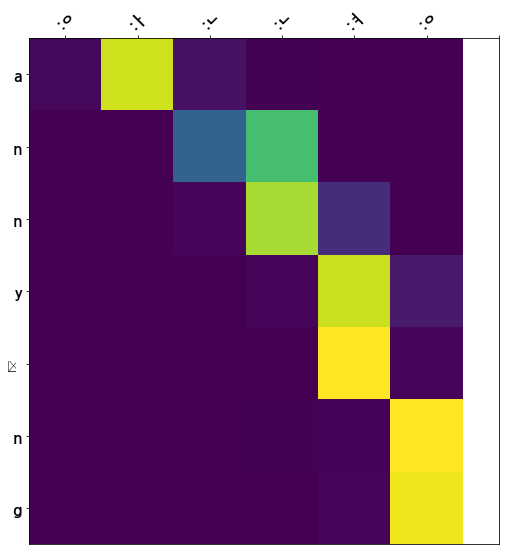

In [34]:
heatmap(e, k, a)

In [39]:
e, k, a = translate('김치')
print(e)

input : 김치
output: kimch'i
['k', 'i', 'm', 'c', 'h', "'", 'i']


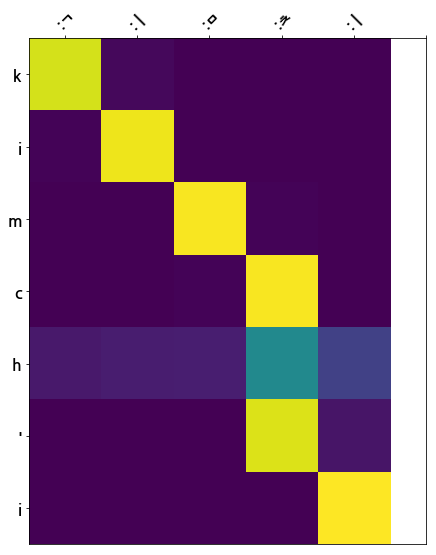

In [40]:
heatmap(e, k, a)